In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [5]:
selected_cell = 'Mast Cells'

In [6]:
estimation = pd.read_csv('GSE14520.Immune.csv',index_col=0)
estimation.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,
GSM362947,0.073478,0.054109,0.775935,0.0,0.0,0.052063,0.044416,0.0,0,0.881802,0.483457
GSM362948,0.050823,0.050650,0.729312,0.0,0.0,0.068892,0.100324,0.0,0,0.882502,0.477183
GSM362949,0.078251,0.050337,0.759259,0.0,0.0,0.039443,0.072710,0.0,0,0.919089,0.402111
GSM362950,0.034227,0.072856,0.749130,0.0,0.0,0.048526,0.095261,0.0,0,0.897630,0.448814
GSM362951,0.050995,0.050251,0.813695,0.0,0.0,0.036582,0.048477,0.0,0,0.932505,0.376955


In [7]:
survival_data = pd.read_csv('GSE14520.Survival.csv',index_col=0)
survival_data.head()

,OS_E,OS,DFS_E,DFS
GSM,,,,
GSM363205,0,58.0,0,58.0
GSM363115,0,66.6,0,66.6
GSM362970,0,67.3,0,67.3
GSM363354,1,10.4,1,10.4
GSM363039,0,52.8,0,52.8


In [8]:
dfs_data = survival_data.filter(['DFS_E', 'DFS'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFS_E']]
dfs_data['DFS_T'] = [time for time in dfs_data['DFS']]
dfs_data.head()

,DFS_E,DFS,DFS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [9]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM362947,0.073478,0.054109,0.775935,0.0,0.0,0.052063,0.044416,0.0,0,0.881802,0.483457,True,50.0,50.0
GSM362948,0.050823,0.050650,0.729312,0.0,0.0,0.068892,0.100324,0.0,0,0.882502,0.477183,True,8.8,8.8
GSM362949,0.078251,0.050337,0.759259,0.0,0.0,0.039443,0.072710,0.0,0,0.919089,0.402111,True,18.2,18.2
GSM362950,0.034227,0.072856,0.749130,0.0,0.0,0.048526,0.095261,0.0,0,0.897630,0.448814,True,30.1,30.1
GSM362952,0.073806,0.054322,0.834425,0.0,0.0,0.023520,0.013927,0.0,0,0.929379,0.390063,False,54.3,54.3


In [10]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM363143,0.045329,0.021924,0.739901,0.0,0.031324,0.043678,0.094770,0.023074,0,-0.006118,1.359107,True,32.6,32.6
GSM363055,0.084647,0.022893,0.709790,0.0,0.063989,0.026943,0.076845,0.014893,0,0.450289,0.991121,False,7.3,7.3
GSM712542,0.064795,0.044344,0.790074,0.0,0.000000,0.039648,0.047416,0.013723,0,0.628000,0.853568,True,4.4,4.4
GSM363054,0.122161,0.000000,0.623796,0.0,0.000495,0.024660,0.217111,0.011777,0,-0.005359,1.278931,False,53.8,53.8
GSM363076,0.073053,0.032804,0.834355,0.0,0.000000,0.022982,0.027220,0.009587,0,0.502291,1.013261,True,23.0,23.0


In [11]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [16]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [17]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.0

In [18]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.89873

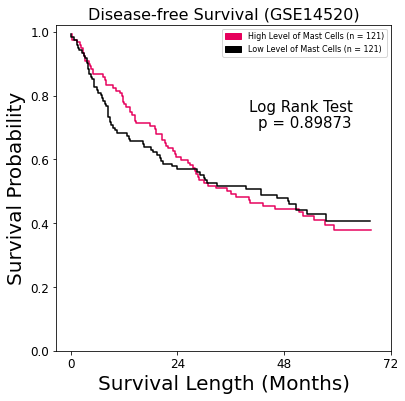

In [19]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of Mast Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Mast Cells (n = %s)'%len(E_low))
plt.text(40,0.75, 'Log Rank Test',fontsize=15)
plt.text(42,0.7, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Disease-free Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.DFS.pdf'%selected_cell,format='pdf')

In [20]:
os_data = survival_data.filter(['OS_E', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS_E']]
os_data['OS_T'] = [time for time in os_data['OS']]
os_data.head()

,OS_E,OS,OS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [21]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM362947,0.073478,0.054109,0.775935,0.0,0.0,0.052063,0.044416,0.0,0,0.881802,0.483457,True,59.2,59.2
GSM362948,0.050823,0.050650,0.729312,0.0,0.0,0.068892,0.100324,0.0,0,0.882502,0.477183,False,61.4,61.4
GSM362949,0.078251,0.050337,0.759259,0.0,0.0,0.039443,0.072710,0.0,0,0.919089,0.402111,True,18.2,18.2
GSM362950,0.034227,0.072856,0.749130,0.0,0.0,0.048526,0.095261,0.0,0,0.897630,0.448814,False,57.5,57.5
GSM362952,0.073806,0.054322,0.834425,0.0,0.0,0.023520,0.013927,0.0,0,0.929379,0.390063,False,54.3,54.3


In [22]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,CD8+ Cells,Tregs,Non-immune cluster,Nk Cells,CD4+ Cells,B Cells,Myeloid,Mast Cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM363143,0.045329,0.021924,0.739901,0.000000,0.031324,0.043678,0.094770,0.023074,0,-0.006118,1.359107,True,32.6,32.6
GSM363055,0.084647,0.022893,0.709790,0.000000,0.063989,0.026943,0.076845,0.014893,0,0.450289,0.991121,False,7.3,7.3
GSM712542,0.064795,0.044344,0.790074,0.000000,0.000000,0.039648,0.047416,0.013723,0,0.628000,0.853568,True,7.5,7.5
GSM363054,0.122161,0.000000,0.623796,0.000000,0.000495,0.024660,0.217111,0.011777,0,-0.005359,1.278931,False,53.8,53.8
GSM363076,0.073053,0.032804,0.834355,0.000000,0.000000,0.022982,0.027220,0.009587,0,0.502291,1.013261,True,23.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM362948,0.050823,0.050650,0.729312,0.000000,0.000000,0.068892,0.100324,0.000000,0,0.882502,0.477183,False,61.4,61.4
GSM363184,0.090353,0.102636,0.579198,0.031347,0.000000,0.019301,0.177166,0.000000,0,0.102802,1.179472,False,16.3,16.3
GSM363186,0.062733,0.025001,0.822531,0.000000,0.000000,0.014527,0.075208,0.000000,0,0.927409,0.393060,True,7.6,7.6
GSM363188,0.068180,0.031245,0.784862,0.000000,0.005325,0.024049,0.086339,0.000000,0,0.931850,0.373564,False,57.3,57.3


In [23]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [24]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
#optimization = int(len(E)/2)

In [25]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.0

In [26]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.01178

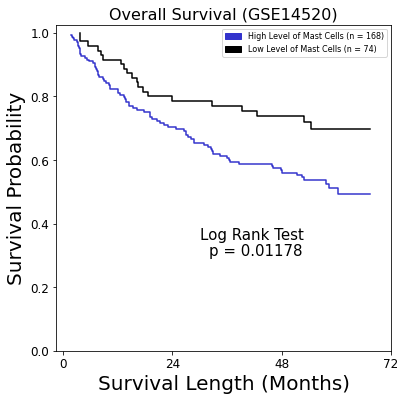

In [27]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of Mast Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Mast Cells (n = %s)'%len(E_low))
plt.text(30,0.35, 'Log Rank Test',fontsize=15)
plt.text(32,0.3, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Overall Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.OS.pdf'%selected_cell,format='pdf')

In [28]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

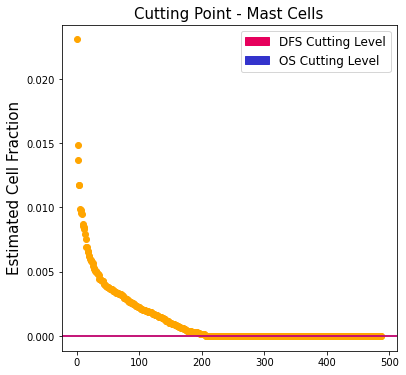

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.title('Cutting Point - %s'%selected_cell,fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')